# Code to Train our DCGAN on MNIST Dataset  

### Import the Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from model import Discriminator,Generator,initialize_weights


### Hyperparameters

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
IMG_CHANNELS = 1 #as
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GENE = 64

transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(IMG_CHANNELS)], [0.5 for _ in range(IMG_CHANNELS)]),
])



### Dataset

In [3]:
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [03:57<00:00, 41708.45it/s] 


Extracting dataset/MNIST\raw\train-images-idx3-ubyte.gz to dataset/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 40440.95it/s]


Extracting dataset/MNIST\raw\train-labels-idx1-ubyte.gz to dataset/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:47<00:00, 34575.04it/s]


Extracting dataset/MNIST\raw\t10k-images-idx3-ubyte.gz to dataset/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 3767160.13it/s]

Extracting dataset/MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/MNIST\raw



### Initialize Generator & Discriminator

In [4]:
disc = Discriminator(IMG_CHANNELS, FEATURES_DISC).to(DEVICE)
gene = Generator(Z_DIM, IMG_CHANNELS, FEATURES_GENE).to(DEVICE)
initialize_weights(disc)
initialize_weights(gene)

opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gene = optim.Adam(gene.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss() #Loss Function 

In [5]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(DEVICE)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0  #For writing to TensorBoard

gene.train()
disc.train()


Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

### Training Loop

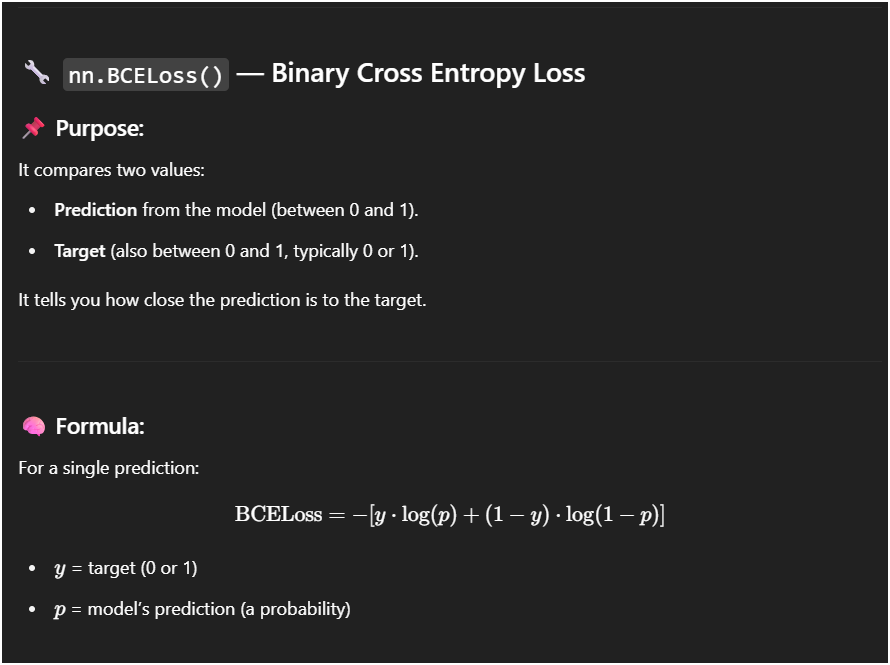

In [7]:
for _ in range(NUM_EPOCHS):
    for batch_idx , (real, _) in enumerate(loader):
        real = real.to(DEVICE)
        random_noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(DEVICE)
        fake = gene(random_noise)
        #Train Discriminator to maximize [log(D(x)) + log(1 - D(G(z)))]
        
        disc_real = disc(real).reshape(-1)
        
        #Since the discriminator should output 1 for real images, we use torch.ones_like() as the target when calculating the loss for real images.
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real)) 
        disc_fake = disc(fake).reshape(-1)  #Flattens the output to 1D tensor so that computation becomes easier
        
        #Since the Discriminator should output 0 for fake images, we use torch.zeros_like() as the target when calculating the loss for the fake images.
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_fake + loss_disc_real) / 2 
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        
        #Train Generator to minimize[log(1 - D(G(z)))] or maximize[ log(D(G(z))) ]
        output = disc(fake)
        loss_gen = criterion(output, torch.ones_like(output))
        gene.zero_grad()
        loss_gen.backward()
        opt_gene.step()
        
        #Print the training results on TensorBoard
        if batch_idx % 100 == 0 :
            
            with torch.no_grad():
                fake  = gene(fixed_noise)
                #Take 32 example 
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
                
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
            step += 1
        